## PyTorch Tutorial
MILA, November 2017

By Sandeep Subramanian

## Generative Adversarial Networks (GAN) - DCGANs

In [1]:
import time
import numpy as np
from __future__ import print_function

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Variable

In [3]:
import torchvision
import torchvision.transforms

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

### Define image transformations &  Initialize datasets

In [5]:
mnist_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, transform=mnist_transforms, download=True)

In [6]:
trainloader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True, num_workers=2)

### Create DCGAN Generator

![caption](images/dcgan_g.png)


      (deconv1): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)

      (deconv2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)

      (deconv3): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)

      (deconv4): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(3, 3), bias=False)


In [7]:
class Generator(nn.Module):
    """DCGAN Generator."""
    def __init__(self, z_dim=128, num_filters=32):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.num_filters = num_filters
        
        # 1 x 1 -> 4 x 4
        self.deconv1 = nn.ConvTranspose2d(
            in_channels=z_dim, out_channels=num_filters * 4,
            kernel_size=(4, 4), bias=False
        )
        self.bn1 = nn.BatchNorm2d(num_filters * 4)
        
        # 4 x 4 -> 8 x 8
        self.deconv2 = nn.ConvTranspose2d(
            in_channels=num_filters * 4, out_channels=num_filters * 2,
            kernel_size=(4, 4), stride=2, padding=1, bias=False,
        )
        self.bn2 = nn.BatchNorm2d(num_filters * 2)
        
        # 8 x 8 -> 16 x 16
        self.deconv3 = nn.ConvTranspose2d(
            in_channels=num_filters * 2, out_channels=num_filters,
            kernel_size=(4, 4), stride=2, padding=1, bias=False,
        )
        self.bn3 = nn.BatchNorm2d(num_filters)
        
        # 16 x 16 -> 28 x 28
        self.deconv4 = nn.ConvTranspose2d(
            in_channels=num_filters, out_channels=1,
            kernel_size=(4, 4), stride=2, padding=3, bias=False,
        )
        
    def forward(self, x):
        x = F.relu(self.bn1(self.deconv1(x)))
        x = F.relu(self.bn2(self.deconv2(x)))
        x = F.relu(self.bn3(self.deconv3(x)))
        return F.tanh(self.deconv4(x))

### Create DCGAN Discriminator

![caption](images/dcgan_d.png)

    
    (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    
    (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    
    (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    
    (conv4): Conv2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)


In [8]:
class Discriminator(nn.Module):
    """DCGAN Generator."""
    def __init__(self, num_filters=32):
        super(Discriminator, self).__init__()
        self.num_filters = num_filters
        # 28 x 28 -> 14 x 14
        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=num_filters,
            kernel_size=(4, 4), stride=2, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(num_filters)
        
        # 14 x 14 -> 7 x 7
        self.conv2 = nn.Conv2d(
            in_channels=num_filters, out_channels=num_filters * 2,
            kernel_size=(4, 4), stride=2, padding=1, bias=False,
        )
        self.bn2 = nn.BatchNorm2d(num_filters * 2)
        
        # 7 x 7 -> 3 x 3
        self.conv3 = nn.Conv2d(
            in_channels=num_filters * 2, out_channels=num_filters * 4,
            kernel_size=(4, 4), stride=2, padding=1, bias=False,
        )
        self.bn3 = nn.BatchNorm2d(num_filters * 4)
        
        # 3 x 3 -> 1 x 1
        self.conv4 = nn.Conv2d(
            in_channels=num_filters * 4, out_channels=1,
            kernel_size=(4, 4), stride=2, padding=1, bias=False,
        )

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)), 0.2)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2)
        return F.sigmoid(self.conv4(x)).squeeze()

In [9]:
cuda_available = torch.cuda.is_available()

### Initialize Generator & Discriminator

In [10]:
generator = Generator()
discriminator = Discriminator()
if cuda_available:
    generator = generator.cuda()
    discriminator = discriminator.cuda()

loss = nn.BCELoss()
optimizer_g = torch.optim.Adam(generator.parameters(), lr=2e-4)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=2e-4)

### Training Loop

In [11]:
ctr = 0
z_dim = 128

minibatch_disc_losses = []
minibatch_gen_losses = []

for epoch in range(50):
    losses = []
    # Train
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        ctr += 1
        if cuda_available:
            inputs, targets = inputs.cuda(), targets.cuda()
        
        inputs, targets = Variable(inputs), Variable(targets)
        
        zeros = Variable(torch.zeros(inputs.size(0)))
        ones = Variable(torch.ones(inputs.size(0)))

        if cuda_available:
            zeros, ones = zeros.cuda(), ones.cuda()
                
        ############################
        # (1) Update Discriminator 
        ############################
        
        # Sample z ~ N(0, 1)
        minibatch_noise = Variable(torch.from_numpy(
            np.random.randn(inputs.size(0), z_dim, 1, 1).astype(np.float32)
        ))

        if cuda_available:
            minibatch_noise = minibatch_noise.cuda()
        
        # Zero gradients for the discriminator
        optimizer_d.zero_grad()
        
        # Train with real examples
        d_real = discriminator(inputs)

        d_real_loss = loss(d_real, ones)  # Train discriminator to recognize real examples
        d_real_loss.backward()
        
        # Train with fake examples from the generator
        fake = generator(minibatch_noise).detach()  # Detach to prevent backpropping through the generator
        d_fake = discriminator(fake)

        d_fake_loss = loss(d_fake, zeros)  # Train discriminator to recognize generator samples
        d_fake_loss.backward()
        minibatch_disc_losses.append(d_real_loss.data[0] + d_fake_loss.data[0])
        
        # Update the discriminator
        optimizer_d.step()

            
        ############################
        # (2) Update Generator
        ############################

        # Zero gradients for the generator
        optimizer_g.zero_grad()
        
        # Sample z ~ N(0, 1)
        minibatch_noise = Variable(torch.from_numpy(
            np.random.randn(inputs.size(0), z_dim, 1, 1).astype(np.float32)
        ))

        if cuda_available:
            minibatch_noise = minibatch_noise.cuda()

        d_fake = discriminator(generator(minibatch_noise))
        g_loss = loss(d_fake, ones)  # Train generator to fool the discriminator into thinking these are real.

        g_loss.backward()

        # Update the generator
        optimizer_g.step()

        minibatch_gen_losses.append(g_loss.data[0])
    
    print('Generator loss : %.3f' % (np.mean(minibatch_gen_losses)))
    print('Discriminator loss : %.3f' % (np.mean(minibatch_disc_losses)))

Generator loss : 3.891
Discriminator loss : 0.209
Generator loss : 4.686
Discriminator loss : 0.130
Generator loss : 5.251
Discriminator loss : 0.101
Generator loss : 5.329
Discriminator loss : 0.091
Generator loss : 5.144
Discriminator loss : 0.100
Generator loss : 4.938
Discriminator loss : 0.123
Generator loss : 4.703
Discriminator loss : 0.150
Generator loss : 4.498
Discriminator loss : 0.173
Generator loss : 4.313
Discriminator loss : 0.197
Generator loss : 4.160
Discriminator loss : 0.214
Generator loss : 4.025
Discriminator loss : 0.232
Generator loss : 3.911
Discriminator loss : 0.246
Generator loss : 3.810
Discriminator loss : 0.263
Generator loss : 3.716
Discriminator loss : 0.276
Generator loss : 3.635
Discriminator loss : 0.287
Generator loss : 3.567
Discriminator loss : 0.298
Generator loss : 3.504
Discriminator loss : 0.308
Generator loss : 3.449
Discriminator loss : 0.317
Generator loss : 3.402
Discriminator loss : 0.325
Generator loss : 3.356
Discriminator loss : 0.332


### Sample from the Generator

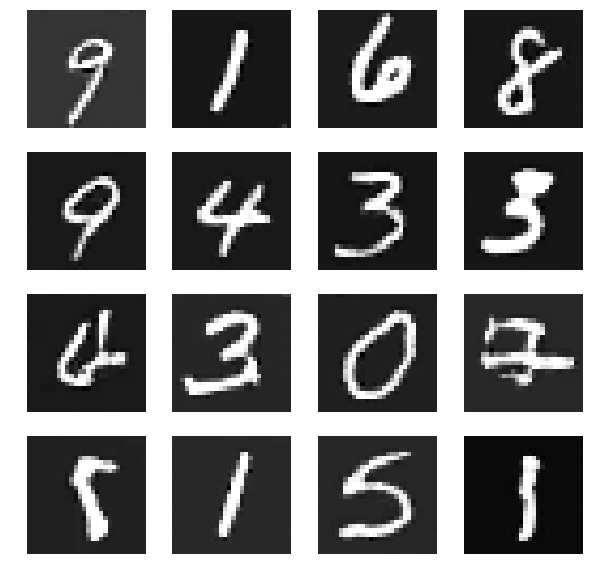

In [13]:
# Set generator in evaluation mode to use running means and averages for Batchnorm
generator.eval()

# Sample z ~ N(0, 1)
minibatch_noise = Variable(torch.from_numpy(
    np.random.randn(16, z_dim, 1, 1).astype(np.float32)
))

if cuda_available:
    minibatch_noise = minibatch_noise.cuda()

fakes = generator(minibatch_noise)

fig = plt.figure(figsize=(10, 10))
idx = 1
for ind, fake in enumerate(fakes):
    fig.add_subplot(4, 4, ind + 1)
    plt.imshow(fake.data.cpu().numpy().reshape(28, 28), cmap='gray')
    plt.axis('off')